#  Прогнозирование количества заказов такси на следующий час

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [54]:
#открываем файл
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
except FileNotFoundError: 
    data = pd.read_csv('datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [55]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [57]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков нет, отсортируем индексы и выполним ресемплирование по 1 часу. 

In [58]:
data = data.sort_index()

In [59]:
data = data.resample('1H').sum()

In [60]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

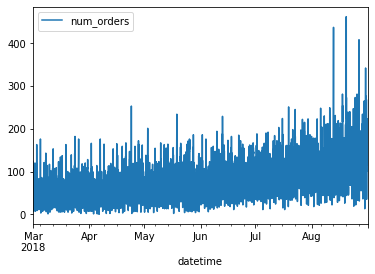

In [61]:
data.plot()

In [62]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [63]:
print(data.index.is_monotonic)

True


Пропусков в данных нет, даты упорядочены, проведем анализ данных.

## Анализ

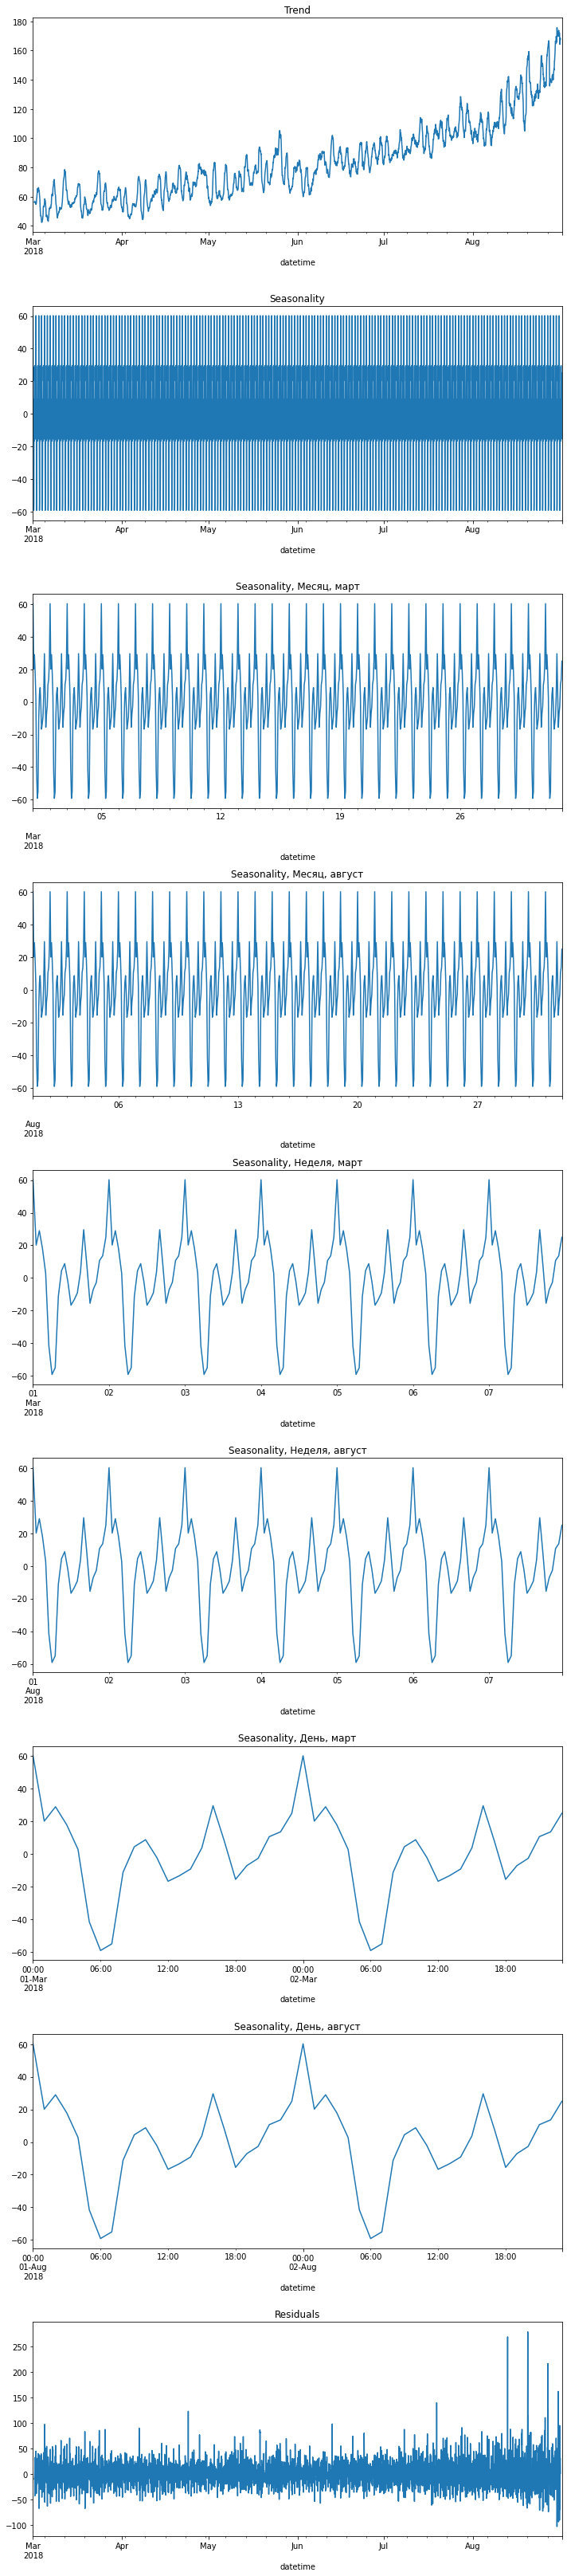

In [64]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 45))

plt.subplot(911)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(912)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(913)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title('Seasonality, Месяц, март')
plt.subplot(914)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.title('Seasonality, Месяц, август')
plt.subplot(915)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()
plt.title('Seasonality, Неделя, март')
plt.subplot(916)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot()
plt.title('Seasonality, Неделя, август')
plt.subplot(917)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Seasonality, День, март')
plt.subplot(918)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot()
plt.title('Seasonality, День, август')

plt.subplot(919)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику тренда мы видим, что число заказов планомерно увеличивается к августу. 
Так же по графикам наблюдается сезонность: рост числа заказов в вечернее и ночное время, снижение с полуночи до 6 утра.

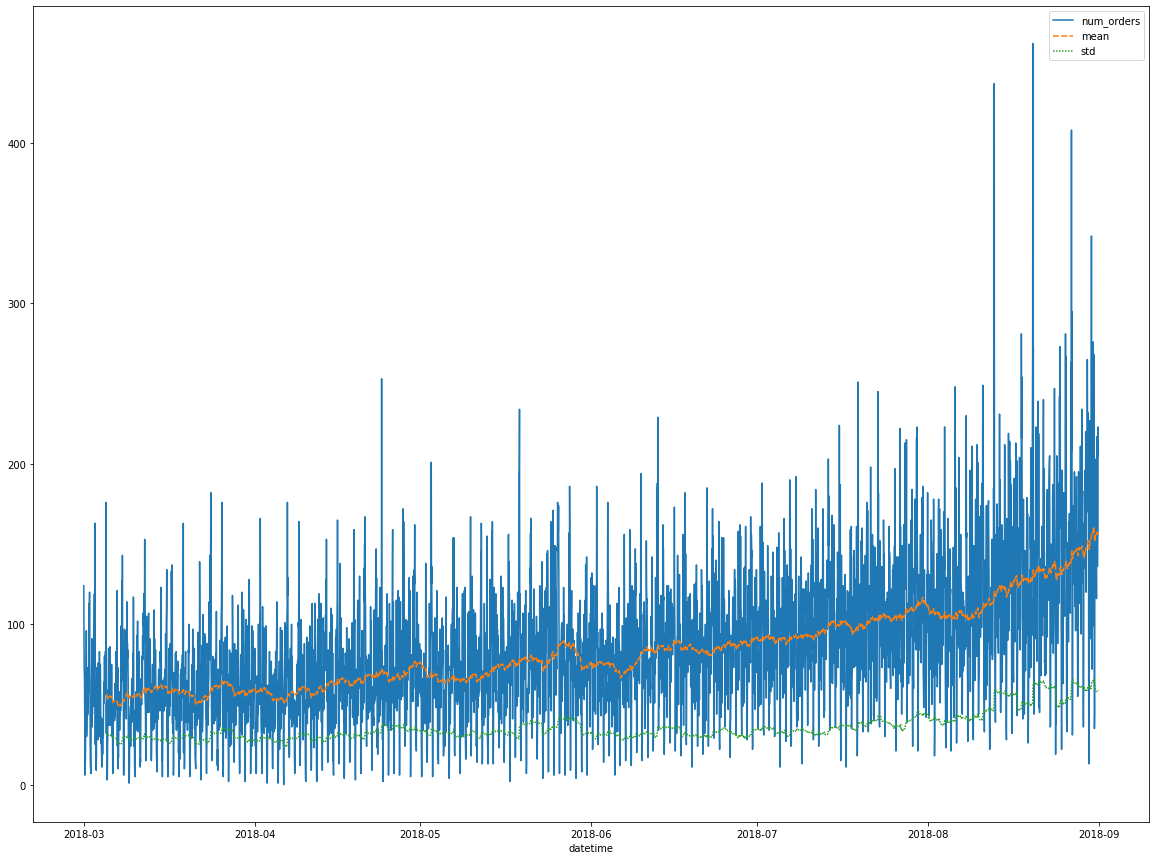

In [65]:
#Изобразим на графике среднее и стандартное отклонение.
plt.figure(figsize=(20, 15))

data_new = data.copy()
data_new['mean'] = data_new['num_orders'].rolling(100).mean()
data_new['std'] = data_new['num_orders'].rolling(100).std()
sns.lineplot(data=data_new); 

## Обучение

Добавим признаки в таблицу. Для этого созданим функцию `make features`.

In [66]:
def make_features(data, max_lag, rolling_mean_size):
    """Функция добавляет столбцы с месяцем, днем, днем недели, 
    отстающими значениями, скользящим средним"""
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [67]:
make_features(data, 28, 20)

In [68]:
data

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,169.35
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,163.85
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,157.75


Далее делим данные на обучающую и тестовую выборки.

In [69]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [70]:
#Линейная регрессия
linreg = LinearRegression()
tss = TimeSeriesSplit(n_splits=10)
mse = abs(cross_val_score(linreg, features_train, target_train,  scoring='neg_mean_squared_error', cv=tss).mean())

print("Linear Regression")
print("MSE =", mse)
print("RMSE =", mse ** 0.5)
print()

Linear Regression
MSE = 693.6487282943281
RMSE = 26.337211854984346



In [71]:
#Дерево решений
grid_tree = { 
        'max_depth': range (1, 15, 1),
    
}

gd_sr_tree = GridSearchCV(DecisionTreeRegressor(), 
                     param_grid=grid_tree,
                     n_jobs=-1,
                     cv=tss,
                     scoring='neg_mean_squared_error',
                     verbose=1)
gd_sr_tree.fit(features_train, target_train)
print('Лучшее значение глубины:', gd_sr_tree.best_params_)
print("RMSE =", abs(gd_sr_tree.best_score_) ** 0.5)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Лучшее значение глубины: {'max_depth': 5}
RMSE = 29.85131926485118


In [72]:
#Случайный лес
grid_forest = { 
    'n_estimators': range (20, 250, 40),
    'max_depth': range (3,16, 3),
    
}

gd_sr_forest = GridSearchCV(RandomForestRegressor(), 
                     param_grid=grid_forest,
                     n_jobs=-1,
                     cv=tss,
                     scoring='neg_mean_squared_error',
                     verbose=1)
gd_sr_forest.fit(features_train, target_train)
print(gd_sr_forest.best_params_)
print("Случайный лес при лучших параметрах,  RMSE =", abs(gd_sr_forest.best_score_) ** 0.5)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'max_depth': 15, 'n_estimators': 140}
Случайный лес при лучших параметрах,  RMSE = 25.00056692454732


In [73]:
#LGBM
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.5, 1],
    'n_estimators': range (20, 200, 30),
}

gbm = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', cv=tss)
gbm.fit(features_train, target_train)

print('Лучшие параметры:', gbm.best_params_)
print("RMSE =", abs(gbm.best_score_) ** 0.5)

Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 80}
RMSE = 24.91095896989702


Наилучший результат RMSE 24,9 у LGBM. Проверим на тестовой выборке.

## Тестирование

In [74]:
model = lgb.LGBMRegressor(num_leaves=31,learning_rate=0.1,n_estimators=80)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print("RMSE =", mse ** 0.5)

RMSE = 41.887325514030366


RMSE в допустимых значениях, меньше 48. 